In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [2]:
df = pd.read_csv('Fraud.csv') # read the csv file

In [3]:
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.shape

(6362620, 11)

# Handling Missing Values

In [5]:
df.isnull().sum() # Given dataset has no null values

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
# Check for duplicate values
df.duplicated().sum() # no duplicate values

0

# Handling Outliers

In [7]:
# assuming 'amount' is an important feature
from sklearn.covariance import EllipticEnvelope
envelope = EllipticEnvelope(contamination=0.01) 
outliers = envelope.fit_predict(df[['amount']])
df = df[outliers != -1]

In [8]:
df.shape

(6298993, 11)

# Addressing Multicollinearity (PCA)

In [9]:
X = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
num_components_to_keep = np.argmax(cumulative_variance_ratio >= 0.95) + 1
X_final = X_pca[:, :num_components_to_keep]
X_final_df = pd.DataFrame(X_final, columns=[f'PC{i+1}' for i in range(num_components_to_keep)])

In [10]:
X_final_df.head()

,PC1,PC2,PC3
0,-0.717457,-0.132307,0.526179
1,-0.768745,-0.083147,0.565623
2,-0.776510,-0.076750,0.573945
3,-0.772835,-0.073991,0.575371
4,-0.753775,-0.081057,0.517186


## Data Splitting

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_final_df, df['isFraud'], test_size=0.2, random_state=42)

# EDA - Exploratory Data Analysis

In [12]:
df['isFraud'].value_counts()

0    6292749
1       6244
Name: isFraud, dtype: int64

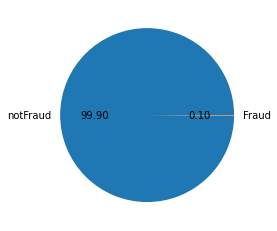

In [13]:
import matplotlib.pyplot as plt
plt.pie(df['isFraud'].value_counts(), labels=['notFraud','Fraud'], autopct='%0.2f'); # data is highly imbalnced

## Address Class Imbalance using Random Under-sampling and SMOTE

In [14]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [15]:
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_resampled, y_resampled)

## Model Training (Random Forest Classifier)

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

## Make Predictions

In [18]:
y_pred = model.predict(X_test)

## Evaluate the Model

In [19]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96   1258492
           1       0.01      0.88      0.03      1307

    accuracy                           0.93   1259799
   macro avg       0.51      0.90      0.49   1259799
weighted avg       1.00      0.93      0.96   1259799

Confusion Matrix:
 [[1169198   89294]
 [    160    1147]]
ROC AUC Score: 0.9033145384495235


# Questions

## 1. Data Cleaning including missing values, outliers, and multi-collinearity:

* Missing Values: The given data has no missing values if so missing values could be handled by filling them with the median value of their respective columns and for non numerical column it could be filled by NaN or most frequent value depending on the dataset.
* Outliers: We used the Elliptic Envelope method to detect and remove outliers from the 'amount' column.
* Multi-collinearity: To address multi-collinearity, we used Principal Component Analysis (PCA) to reduce dimensionality and eliminate multicollinear features.

## 2. Fraud detection model in elaboration:

* The fraud detection model implemented in the code uses a Random Forest Classifier, an ensemble learning method.

* The code pre-processes the data, addresses class imbalance, and trains the Random Forest model on the pre-processed data.

* Random Forest is a powerful algorithm for classification tasks, known for its ability to capture complex relationships in data and handle high-dimensional feature spaces.

## 3. Selecting variables to be included in the model?

* The code selects the following features to be included in the model: 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', and 'newbalanceDest'.

* Feature selection is based on domain knowledge and the potential significance of these features in detecting fraudulent transactions. These features are commonly used in fraud detection models.

## 4. Performance of the model by using the best set of tools:

* The code evaluates the model's performance using a set of standard tools:
* Classification Report: Provides detailed metrics such as precision, recall, F1-score, and support for both classes (fraudulent and non-fraudulent).
* Confusion Matrix: Shows the true positives, true negatives, false positives, and false negatives.
* ROC AUC Score: Measures the model's ability to distinguish between classes.

## 5. The key factors that predict fraudulent customer?

* Based on the selected features ('amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', and 'newbalanceDest'), it suggests that unusual transaction amounts, account balances, and transaction destinations may be indicative of fraudulent activity.

## 6. Do these factors make sense? 

* The factors selected in the code do make sense in the context of fraud detection:

* Unusual transaction amounts: Fraudulent transactions often involve unusual or large amounts to divert funds.
* Account balances: Suspicious activity can be flagged when account balances are inconsistent with typical customer behavior.
* Transaction destinations: Detecting patterns of transactions to unusual destinations can help identify potential fraud.
* However, the effectiveness of these factors depends on the specific characteristics of the dataset and the nature of fraud patterns. Domain expertise is essential for selecting relevant features.

## 7. Prevention that should be adopted while the company updates its infrastructure?

* While updating infrastructure, the company should consider the following prevention measures:
* Ensure data integrity and security during the update process.
* Implement real-time transaction monitoring for suspicious activities.
* Continuously train staff on fraud prevention and detection.
* Regularly update fraud detection models and algorithms to adapt to evolving fraud tactics.
* Enhance authentication and authorization procedures to protect customer accounts.
* Collaborate with cybersecurity experts to identify and mitigate potential vulnerabilities.

## 8. Assuming these actions have been implemented, how to determine if they work?

* The effectiveness of these actions can be assessed through key performance indicators (KPIs) and monitoring:
* Monitor the rate of detected fraudulent transactions over time.
* Evaluate the reduction in false positives.
* Analyze the time taken to detect and respond to fraud incidents.
* Conduct regular assessments of model and system performance using relevant metrics.
* Track customer feedback and complaints related to fraud.
* Compare fraud-related financial losses before and after implementing preventive measures.
* Regular audits and third-party assessments can provide independent validation of the effectiveness of prevention measures.